 ## Setup

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms.v2 as T
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import wandb
from torch.utils.data import Subset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


 ## Paths

In [2]:
COCO_PATH = "../../data/coco/"  # change this
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

DS_SIZE = (0.1, 0.1, 0.1)

BATCH_SIZE = 64

In [3]:
class YOLOKeypointDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transform=None, grid_size=32, num_keypoints=17, filter_without_keypoints=True):
        super().__init__(img_folder, ann_file)
        self.coco = self.coco
        self.transform = transform
        self.grid_size = grid_size
        self.num_keypoints = num_keypoints
        self.image_size = 256  # resize all images

        if filter_without_keypoints:
            # Keep only images with at least one annotation with keypoints
            valid_ids = []
            for img_id in self.ids:
                anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
                if any(ann.get("num_keypoints", 0) > 0 for ann in anns):
                    valid_ids.append(img_id)
            self.ids = valid_ids

    def __getitem__(self, index):
        try:
            img, target = super().__getitem__(index)
        except FileNotFoundError as e:
            img_info = self.coco.imgs[self.ids[index]]
            print(f"[Warning] Skipping missing file: {img_info.get('file_name', 'unknown')} (index {index})")
            return self.__getitem__((index + 1) % len(self))

        img_info = self.coco.imgs[self.ids[index]]
        orig_w, orig_h = img_info['width'], img_info['height']

        if self.transform:
            img = self.transform(img)

        target_tensor = torch.zeros((self.grid_size, self.grid_size, self.num_keypoints * 3))
        for ann in target:
            if ann["num_keypoints"] == 0:
                continue
            kps = torch.tensor(ann["keypoints"]).view(-1, 3)
            for i, (x, y, v) in enumerate(kps):
                if v > 0:
                    # Scale keypoints to resized image
                    x_resized = x * self.image_size / orig_w
                    y_resized = y * self.image_size / orig_h
                    grid_x = int(x_resized * self.grid_size / self.image_size)
                    grid_y = int(y_resized * self.grid_size / self.image_size)
                    if 0 <= grid_x < self.grid_size and 0 <= grid_y < self.grid_size:
                        target_tensor[grid_y, grid_x, i*3 + 0] = x_resized / self.image_size
                        target_tensor[grid_y, grid_x, i*3 + 1] = y_resized / self.image_size
                        target_tensor[grid_y, grid_x, i*3 + 2] = 1.0
        return img, target_tensor


transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32)
])




c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
train_dataset = YOLOKeypointDataset(IMG_DIR_TRAIN, ANN_FILE_TRAIN, transform)
val_dataset = YOLOKeypointDataset(IMG_DIR_VAL, ANN_FILE_VAL, transform)

# Calculate split sizes
train_size = int(len(train_dataset) * DS_SIZE[0])
val_size = int(len(val_dataset) * DS_SIZE[1])
test_size = int(len(val_dataset) * DS_SIZE[2])

# For train: random subset of train_dataset
train_indices = random.sample(range(len(train_dataset)), train_size)
train_subset = Subset(train_dataset, train_indices)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)

# For val: use first val_size samples from val_dataset
val_indices = list(range(val_size))
val_subset = Subset(val_dataset, val_indices)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

# For test: use next test_size samples from val_dataset (second half)
test_start = len(val_dataset) // 2
test_indices = list(range(test_start, test_start + test_size))
test_subset = Subset(val_dataset, test_indices)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

loading annotations into memory...
Done (t=5.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [5]:
class YOLOKeypointNet(nn.Module):
    def __init__(self, num_keypoints=17, grid_size=32):
        super().__init__()
        self.backbone = torchvision.models.resnet18(weights="DEFAULT")
        self.backbone.fc = nn.Identity()
        # for param in self.backbone.parameters():
        #     param.requires_grad = False  # lock backbone

        self.head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_keypoints * 3, kernel_size=1)  # (x, y, vis) per keypoint
        )
        self.grid_size = grid_size
        self.num_keypoints = num_keypoints

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), 512, 1, 1)
        x = torch.nn.functional.interpolate(x, size=(self.grid_size, self.grid_size), mode="bilinear")
        x = self.head(x)
        return x.permute(0, 2, 3, 1)  # [B, G, G, K*3]

In [6]:
def keypoint_loss(pred, target):
    mask = target[..., 2::3] > 0  # visibility mask
    pos_loss = ((pred[..., 0::3] - target[..., 0::3])**2 +
                (pred[..., 1::3] - target[..., 1::3])**2)
    conf_loss = ((pred[..., 2::3] - target[..., 2::3])**2)
    total_loss = (pos_loss * mask).sum() + conf_loss.sum()
    return total_loss / target.size(0)


In [7]:
model = YOLOKeypointNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

wandb_config = {
    "epochs": 10,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "batch_size": BATCH_SIZE,
    "train_size": len(train_dataset),
    "val_size": len(val_dataset),
    "model": "YOLOKeypointNet",
    "criterion": "keypoint_loss",
    "optimizer": "Adam",
    "num_keypoints": 17,
    "grid_size": 32,
    "device": str(device),
}

wandb.init(
    entity="fejowo5522-",
    project="NN_Project",
    config=wandb_config,
    group="KeypointDetectionYolo"
)

wandb: Currently logged in as: fejowo5522 (fejowo5522-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
for epoch in range(10):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for imgs, targets in loop:
        imgs = imgs.to(device)
        targets = targets.to(device)

        preds = model(imgs)
        loss = keypoint_loss(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_imgs, val_targets in val_loader:
            val_imgs = val_imgs.to(device)
            val_targets = val_targets.to(device)
            val_preds = model(val_imgs)
            v_loss = keypoint_loss(val_preds, val_targets)
            val_loss += v_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    wandb.log({"epoch": epoch, "train_loss": avg_train_loss, "val_loss": avg_val_loss})

    print(f"Epoch {epoch+1}, avg train loss: {avg_train_loss:.4f}, avg val loss: {avg_val_loss:.4f}")


Epoch 1:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1, avg train loss: 116.5783, avg val loss: 47.8725


Epoch 2:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2, avg train loss: 47.0633, avg val loss: 43.4024


Epoch 3:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3, avg train loss: 43.6424, avg val loss: 40.4228


Epoch 4:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4, avg train loss: 40.8162, avg val loss: 37.4768


Epoch 5:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5, avg train loss: 37.1175, avg val loss: 33.2559


Epoch 6:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6, avg train loss: 33.4268, avg val loss: 31.2259


Epoch 7:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7, avg train loss: 32.3336, avg val loss: 30.6899


Epoch 8:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8, avg train loss: 31.9363, avg val loss: 30.4350


Epoch 9:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9, avg train loss: 31.7644, avg val loss: 30.3161


Epoch 10:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10, avg train loss: 31.5977, avg val loss: 30.2539


In [9]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
train loss,█▂▂▂▁▁▁▁▁▁
val loss,█▆▅▄▂▁▁▁▁▁
epoch,9
train loss,31.5977
val loss,30.25392


In [17]:
def visualize_predictions(img, pred, threshold=0.1, apply_sigmoid=True):
    img = img.permute(1, 2, 0).cpu().numpy()
    pred = pred.cpu().detach().numpy()

    # Optionally apply sigmoid to confidence channel
    if apply_sigmoid:
        pred[..., 2::3] = 1 / (1 + np.exp(-pred[..., 2::3]))

    confs = pred[..., 2::3]
    print(f"Conf min: {confs.min():.4f}, max: {confs.max():.4f}, mean: {confs.mean():.4f}")
    detected = (confs > threshold).sum()
    print(f"Keypoints detected above threshold {threshold}: {detected}")

    plt.imshow(img)
    G = pred.shape[0]
    for y in range(G):
        for x in range(G):
            for i in range(17):
                conf = pred[y, x, i * 3 + 2]
                if conf > threshold:
                    px = pred[y, x, i * 3 + 0] * 256
                    py = pred[y, x, i * 3 + 1] * 256
                    plt.scatter([px], [py], c='r', s=10)
    plt.show()


Ground truth keypoints:
Conf min: 0.0000, max: 1.0000, mean: 0.0009
Keypoints detected above threshold 0.1: 15

Conf min: 0.0000, max: 1.0000, mean: 0.0009
Keypoints detected above threshold 0.1: 15


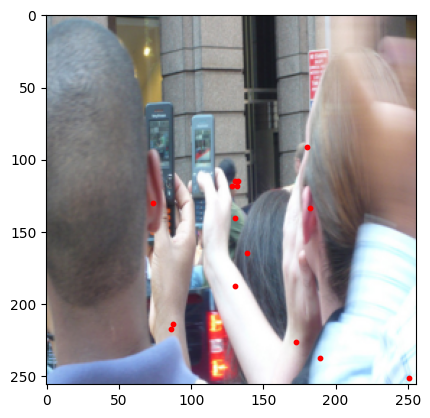

Predicted keypoints:
Conf min: 0.4923, max: 0.5085, mean: 0.5003
Keypoints detected above threshold 0.1: 17408

Conf min: 0.4923, max: 0.5085, mean: 0.5003
Keypoints detected above threshold 0.1: 17408


KeyboardInterrupt: 

In [ ]:
# Get a random sample from the test set
idx = random.randint(0, len(test_subset) - 1)
img, gt = test_subset[idx]

# Move image to device and add batch dimension
img_input = img.unsqueeze(0).to(device)

# Get model prediction
model.eval()
with torch.no_grad():
    pred = model(img_input)[0].cpu()

    # Visualize ground truth keypoints
    print("Ground truth keypoints:")
    visualize_predictions(img, gt, threshold=0.1, apply_sigmoid=False)

# Visualize prediction
print("Predicted keypoints:")
visualize_predictions(img, pred, threshold=0.1, apply_sigmoid=True)